#Initialization

In [298]:
%%capture
! pip install stable-baselines3

In [299]:
import math
import random
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler

In [300]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

In [301]:
samples = [[-0.6810, -0.7323, -0.3519],
        [ 0.9754, -0.2205, -0.9598],
        [ 0.8309, -0.5564, -0.8232],
        [ 0.4757,  0.8796,  0.8216],
        [-0.9221, -0.3869,  0.8180],
        [-0.9108, -0.4129,  0.2524],
        [-0.1120, -0.9937, -0.8391],
        [ 0.5760,  0.8175,  0.6597],
        [ 0.4632, -0.8863, -0.1590],
        [ 0.5347,  0.8450, -0.4712],
        [ 0.5242,  0.8516, -0.9269],
        [-0.8494, -0.5277,  0.9623],
        [ 0.8243, -0.5661, -0.8888],
        [-0.9457, -0.3252, -0.5394],
        [ 0.9998, -0.0188, -0.7901],
        [-0.9918, -0.1282,  0.9201]]

num_envs = 16

env1_name = "Pendulum-v1"
env2_name = "MountainCarContinuous-v0"

env1 = gym.make(env1_name)
env2 = gym.make(env2_name)

envs1 = make_vec_env(env1_name, n_envs=num_envs)
envs2 = make_vec_env(env2_name, n_envs=num_envs)

p_envs_ids = [env1_name, env2_name ]
p_envs = {env1_name: envs1,
          env2_name: envs2
          }

#model_ac = ActorCritic(envs=p_envs, env_ids=p_envs_ids, hidden_size=256).to(device)
#model_input = model_ac.create_model_input(samples, env1_name)

#dist, value = model_ac(model_input)
#print(f"dist: {dist}, val: {value}")

#Auxiliar function

In [302]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)

def plot(name, frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(name + ': ' + 'frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

def plot_all(names, rewards):
    clear_output(True)
    plt.figure(figsize=(15,5))  # Adjust the size as needed

    last_reward = {}
    for i, name in enumerate(names):
        plt.subplot(1, 2, i + 1)  # This creates subplots in a 1 row, 2 columns format

        if len(rewards[name]) == 0: last_reward[name] = 'NaN'
        else: last_reward[name] = rewards[name][-1]

        plt.title(f'{name}, reward: {[last_reward[name]]}')
        plt.plot(rewards[name])

    plt.tight_layout()  # This automatically adjusts subplots to fit into the figure area.
    plt.show()

def test_env(model, env, id_env, max_step, vis=False):

    state = torch.FloatTensor(env.reset()[0]).unsqueeze(0)
    if vis: env.render()
    done = False
    total_reward = 0
    step = 0
    while not done:
        #state = torch.FloatTensor(state).unsqueeze(0).to(device)
        #print(state)
        #state = torch.FloatTensor(state).to(device)
        #dist, _ = model(model_input)
        state = np.array(state)
        model_input = model.create_model_input(state, id_env)
        dist, _ = model(model_input)
        next_state, reward, terminated, truncated, _ = env.step(dist.sample().cpu().numpy())
        done = terminated or truncated


        #state = torch.FloatTensor([next_state.squeeze(-1)])#.to(device)
        #state = np.expand_dims( np.array(next_state.squeeze(-1)), 0 )
        #print(f"sq: {[next_state.squeeze(-1)]}")
        #state = torch.FloatTensor([next_state.squeeze(-1)])#.to(device)
        if vis: env.render()
        total_reward += reward
        step += 1
        if step >= max_step:
            break

    return total_reward

#p_env1_name = "Pendulum-v1"
#p_env2_name = "MountainCarContinuous-v0"

#p_env1 = gym.make(env1_name)
#p_env2 = gym.make(env2_name)

#model_PC.load()
#print( test_env(model_PC, p_env1, p_env1_name ) )
#print( test_env(model_PC, p_env2, p_env2_name) )

# Neural Network

In [303]:
class RBFFeatureEncoder:
    def __init__(self, env1, env2, env3, n_component=100):

        self.env1 = env1
        self.env2 = env2
        self.env3 = env3

        data1 = np.array([env1.observation_space.sample() for x in range(10000)]); data1 = np.clip(data1, -1e38, 1e38)
        data2 = np.array([env2.observation_space.sample() for x in range(10000)]); data2 = np.clip(data2, -1e38, 1e38)
        data3 = np.array([env3.observation_space.sample() for x in range(10000)]); data3 = np.clip(data3, -1e38, 1e38)

        self.rbf_sampler1 = RBFSampler(gamma=0.999, n_components=n_component)
        self.rbf_sampler2 = RBFSampler(gamma=0.999, n_components=n_component)
        self.rbf_sampler3 = RBFSampler(gamma=0.999, n_components=n_component)

        self.standard_scaler1 = sklearn.preprocessing.StandardScaler()
        self.standard_scaler2 = sklearn.preprocessing.StandardScaler()
        self.standard_scaler3 = sklearn.preprocessing.StandardScaler()

        self.standard_scaler1.fit(data1)
        self.standard_scaler2.fit(data2)
        self.standard_scaler3.fit(data3)

        transformed_data1 = self.standard_scaler1.transform(data1)
        transformed_data2 = self.standard_scaler2.transform(data2)
        transformed_data3 = self.standard_scaler3.transform(data3)

        self.rbf_sampler1.fit( transformed_data1 )
        self.rbf_sampler2.fit( transformed_data2 )
        self.rbf_sampler3.fit( transformed_data3 )

    def wrapper_encode(self, model, model_input):

        state = model_input['state']
        env_id = model_input['env_id']

        if model.env1_id == env_id:
            transformed_state = self.standard_scaler1.transform([state])
            encoded_state = self.rbf_sampler1.transform(transformed_state).flatten()

        elif model.env2_id == env_id:
            transformed_state = self.standard_scaler2.transform([state])
            encoded_state = self.rbf_sampler2.transform(transformed_state).flatten()

        elif model.env3_id == env_id:
            transformed_state = self.standard_scaler3.transform([state])
            encoded_state = self.rbf_sampler3.transform(transformed_state).flatten()

        return encoded_state

    def encode(self, model, model_input):

        states = model_input['state']
        env_id = model_input['env_id']
        encoded_states = []

        for s in states:
            new_input = model.create_model_input(s,env_id )
            encoded_states.append( self.wrapper_encode(model, new_input) )

        return torch.tensor(encoded_states, dtype=torch.float32)


    @property
    def size(self):
        return self.rbf_sampler1.n_components

In [304]:
class Critic(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Critic, self).__init__()

        self.relu = nn.ReLU()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        state  = x['state']

        state = self.input_layer(state)
        state = self.relu(state)
        state = self.output_layer(state)
        return state


In [305]:
class Actor(nn.Module):
    def __init__(self, input_size, env_outputs, hidden_size, env_ids):
        super(Actor, self).__init__()

        self.env1_id = env_ids[0]
        self.env2_id = env_ids[1]
        self.env1_actions = env_outputs[0]
        self.env2_actions = env_outputs[1]

        self.relu = nn.ReLU()

        self.input_layer = nn.Linear(input_size, hidden_size)

        self.env1_output = nn.Linear(hidden_size, self.env1_actions)
        self.env2_output = nn.Linear(hidden_size, self.env2_actions)

    def forward(self, x):
        state  = x['state']
        env_id = x['env_id']

        state = self.input_layer(state)
        state = self.relu(state)

        if env_id == self.env1_id:   mu = self.env1_output(state)
        elif env_id == self.env2_id: mu = self.env2_output(state)

        return mu


In [306]:
class ActorCritic(nn.Module):
    def __init__(self, envs, env_ids, hidden_size, std=0.0, lr=0.0001):
        super(ActorCritic, self).__init__()

        self.env1_id = env_ids[0]
        self.env2_id = env_ids[1]

        self.envs1   = envs[self.env1_id]
        self.envs2   = envs[self.env2_id]

        self.env1_output = self.envs1.action_space.shape[0]
        self.env2_output = self.envs2.action_space.shape[0]

        self.encoder    = RBFFeatureEncoder(self.envs1, self.envs2, self.envs2)
        self.input_size = self.encoder.size

        print(f"num_inputs1: {self.input_size}, num_outputs_1: {num_outputs_1}, env_id: {env1_id}")
        print(f"num_inputs2: {self.input_size}, num_outputs_2: {num_outputs_2}, env_id: {env2_id}")


        self.critic = Critic(input_size=self.input_size,
                             hidden_size=hidden_size
                             )

        self.actor = Actor(input_size=self.input_size,
                           env_ids=env_ids,
                           env_outputs=[self.env1_output, self.env2_output ],
                           hidden_size=hidden_size
                           )

        self.log_std_env1 = nn.Parameter(torch.ones(1, self.env1_output) * std)
        self.log_std_env2 = nn.Parameter(torch.ones(1, self.env2_output) * std)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        self.apply(init_weights)

    def forward(self, x):

        state  = x['state']
        env_id = x['env_id']

        state = self.encoder.encode(self, x).to(device)
        model_input = self.create_model_input(state, env_id)

        value = self.critic(model_input)
        mu    = self.actor(model_input)

        if env_id == self.env1_id:   std = self.log_std_env1.exp().expand_as(mu)
        elif env_id == self.env2_id: std = self.log_std_env2.exp().expand_as(mu)

        dist  = Normal(mu, std)
        return dist, value

    def create_model_input(self, state, env_id):
         return {'state':state, 'env_id': env_id}

    def save(self, name = 'model.pt', do_print=True ):
        if do_print==True: print("saving weight model")

        torch.save(self.state_dict(),name )

    def load(self, name = 'model.pt'):
        self.load_state_dict(torch.load(name) )
        print(f"loaded: {name}")

#Loss function

In [307]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

In [308]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]

def ppo_update(model, hidden_cascade, optimizer, env_id, ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    total_loss = []
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):

            state = np.array(state)
            model_input = model.create_model_input(state, env_id)
            dist, value = model(model_input) #model(state)

            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)   # calculating log probability on actions

            ratio = (new_log_probs - old_log_probs).exp()  # should not be the fraction instead difference?
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy


            ### new code ###
            #print(f"original loss: {loss}")
            new_probs = new_log_probs.exp()

            value_kl_penalty1 = kl_penalty( hidden_cascade=hidden_cascade,
                                           actual_policy=new_probs,
                                           old_log_policy=old_log_probs
                                           )
            value_kl_penalty2 = torch.clamp(value_kl_penalty1, 1.0 - clip_param, 1.0 + clip_param)
            value_kl_penalty  = torch.min(value_kl_penalty1, value_kl_penalty2)


            value_loss_casc1  = loss_casc(  hidden_cascade=hidden_cascade,
                                           actual_policy=new_probs,
                                           old_log_policy=old_log_probs
                                           )
            value_loss_casc2 = torch.clamp(value_loss_casc1, 1.0 - clip_param, 1.0 + clip_param)
            value_loss_casc  = torch.min(value_loss_casc1, value_loss_casc2)

            loss = loss + value_kl_penalty + value_loss_casc
            #print(value_kl_penalty); print(value_loss_casc)
            total_loss.append(loss)
            #print(f"new loss: {loss}\n")
            ### end new code ###


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return total_loss

In [309]:
def kl_penalty(hidden_cascade, actual_policy, old_log_policy, beta=0.5, omega=0.5, k=3):
    kldiv_loss = nn.KLDivLoss(reduction="batchmean")
    loss = 0

    for _ in range(len(hidden_cascade.keys())):
        loss = - beta*(omega**i) * kldiv_loss(actual_policy, old_log_policy )

    return loss

In [310]:
def loss_casc(hidden_cascade, actual_policy, old_log_policy, omega=2.0, omega12=0.25, k=3):
    kldiv_loss = nn.KLDivLoss(reduction="batchmean")

    loss = - omega12*kldiv_loss( actual_policy[0], old_log_policy[1] )

    for i in range(len(hidden_cascade.keys())):
        if i==0: continue

        loss += - kldiv_loss( actual_policy[i], old_log_policy[i-1] )*omega

        if i < ( len(hidden_cascade) -1 ): # not doing updated on the last one
            loss += - kldiv_loss( actual_policy[i], old_log_policy[i+1] )

    return loss

#Main program

##Initialization for training

In [311]:
num_envs = 16

env1_id = "Pendulum-v1"
env2_id = "MountainCarContinuous-v0"
env_ids = [env1_id, env2_id ]

env1 = gym.make(env1_id)
env2 = gym.make(env2_id)
single_envs = { env1_id: env1,
                env2_id: env2
               }

num_inputs_1  = env1.observation_space.shape[0];    num_outputs_1 = env1.action_space.shape[0]
num_inputs_2  = env2.observation_space.shape[0];    num_outputs_2 = env2.action_space.shape[0]

print(f"num_inputs1: {num_inputs_1}, num_outputs_1: {num_outputs_1}, env_id: {env1_id}")
print(f"num_inputs2: {num_inputs_2}, num_outputs_2: {num_outputs_2}, env_id: {env2_id}")

envs1 = make_vec_env(env1_id, n_envs=num_envs)
envs2 = make_vec_env(env2_id, n_envs=num_envs)

vectorized_envs = { env1_id: envs1,
                    env2_id: envs2
                    }

#Hyper params:
hidden_size      = 256
lr               = 3e-4
num_steps        = 20
mini_batch_size  = 5
ppo_epochs       = 4
threshold_reward = 0

num_inputs1: 3, num_outputs_1: 1, env_id: Pendulum-v1
num_inputs2: 2, num_outputs_2: 1, env_id: MountainCarContinuous-v0


In [312]:
n_hidden_network = 4
hidden_network = {}
for i in range(4):
    hidden_id = 'network'
    if i == 0: hidden_id += '_PC'
    else: hidden_id += '_' + str(i+1)

    hidden_network[hidden_id] = ActorCritic(envs=vectorized_envs, env_ids=env_ids, hidden_size=256, lr=lr).to(device)

print(hidden_network.keys())

#model_PC = ActorCritic(envs=envs, env_ids=envs_ids, hidden_size=256, lr=lr).to(device)
#model_2 = ActorCritic(envs=envs, env_ids=envs_ids, hidden_size=256, lr=lr).to(device)
#model_3 = ActorCritic(envs=envs, env_ids=envs_ids, hidden_size=256, lr=lr).to(device)
#model_4 = ActorCritic(envs=envs, env_ids=envs_ids, hidden_size=256, lr=lr).to(device)

num_inputs1: 100, num_outputs_1: 1, env_id: Pendulum-v1
num_inputs2: 100, num_outputs_2: 1, env_id: MountainCarContinuous-v0
num_inputs1: 100, num_outputs_1: 1, env_id: Pendulum-v1
num_inputs2: 100, num_outputs_2: 1, env_id: MountainCarContinuous-v0
num_inputs1: 100, num_outputs_1: 1, env_id: Pendulum-v1
num_inputs2: 100, num_outputs_2: 1, env_id: MountainCarContinuous-v0
num_inputs1: 100, num_outputs_1: 1, env_id: Pendulum-v1
num_inputs2: 100, num_outputs_2: 1, env_id: MountainCarContinuous-v0
dict_keys(['network_PC', 'network_2', 'network_3', 'network_4'])


# Training

In [313]:
def swtich_enviroment( vectorized_envs, env_ids, env_index):
    env_index += 1
    new_id_env = env_ids[ env_index % 2 ]   # -------- the switch is only for the first two environments
    new_env = vectorized_envs[ new_id_env ]
    return new_env, new_id_env, env_index

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [316]:
def train(main_model, hidden_networks, main_env, optimizer, vect_envs, train_id_env, state, max_frames, early_stop, test_rewards, plot_frequency=1000, do_plot=True, all_ids=None, all_rewards=None):
    frame_idx = 0
    loss = 0
    while frame_idx < max_frames and not early_stop:
        print(f"\rit: {frame_idx}/{max_frames}, loss: {loss}", end="")
        log_probs = []
        values    = []
        states    = []
        actions   = []
        rewards   = []
        masks     = []
        entropy = 0

        for _ in range(num_steps):

            model_input = main_model.create_model_input(state, train_id_env)
            dist, value = main_model(model_input)

            action = dist.sample()
            next_state, reward, done, _ = vect_envs.step(action.cpu().numpy())

            log_prob = dist.log_prob(action)
            entropy += dist.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
            masks.append(torch.FloatTensor(1-done).unsqueeze(1).to(device))

            states.append(torch.FloatTensor(model_input['state'] ).to(device) )
            actions.append(action)

            state = next_state
            frame_idx += 1

            if do_plot==True and frame_idx % plot_frequency == 0:
                test_reward = np.mean([test_env(main_model, main_env, train_id_env, max_step=250) for _ in range(10)])
                test_rewards.append(test_reward)
                #plot(train_id_env, frame_idx, test_rewards)
                plot_all(all_ids, all_rewards)
                if test_reward > threshold_reward: early_stop = True


        model_input = main_model.create_model_input(state, train_id_env)
        _, next_value = main_model(model_input)

        # try with simple TD-error
        returns = compute_gae(next_value, rewards, masks, values)

        returns   = torch.cat(returns).detach()
        log_probs = torch.cat(log_probs).detach()
        values    = torch.cat(values).detach()
        states    = torch.cat(states)
        actions   = torch.cat(actions)
        advantage = returns - values

        loss = ppo_update(main_model, hidden_networks, optimizer, train_id_env, ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)
        loss = torch.mean( torch.stack(loss).float() )


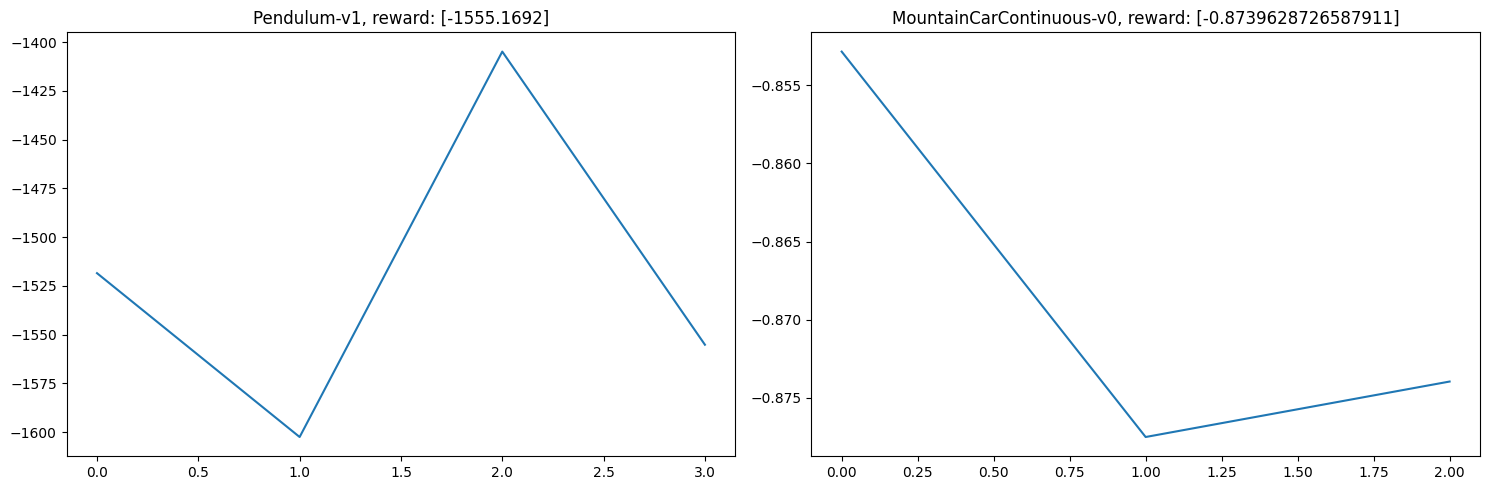

In [ ]:
epoch = 10
epoch_per_train = 50000

swtich_counter = 0
switch_env_frequency = 1

early_stop = False
#test_rewards = []


env_states = {}     # contain state to pass when callicng act
env_step   = {}     # counter for switch
env_reward = {}     # counter for reward
env_index  = 1


for id_env in vectorized_envs.keys():
    env_states[id_env] = vectorized_envs[id_env].reset()
    env_reward[id_env] = []
    env_step[id_env]   = 0

actual_id_env = env_ids[env_index]
actual_vectorized_env = vectorized_envs[actual_id_env]
actual_single_env = single_envs[actual_id_env]

model_PC = hidden_network['network_PC']
model_PC.load()
optimizer = optim.Adam(model_PC.parameters(), lr=lr)

for e in range(epoch):
    model_PC.save()

    #if e > 1 and ( e %  switch_env_frequency == 0):
    if  e %  switch_env_frequency == 0:
        actual_vectorized_env, actual_id_env, env_index = swtich_enviroment(vectorized_envs, env_ids, env_index)
        actual_single_env=single_envs[actual_id_env]
        swtich_counter += 1

    print(f"e: {e}, actual_id_env: {actual_id_env}, env_index: {env_index}, switch: {swtich_counter}")

    actual_state = env_states[actual_id_env]
    train(main_model=model_PC,
          hidden_networks=hidden_network,
          main_env=actual_single_env,
          optimizer=optimizer,
          vect_envs=actual_vectorized_env,
          train_id_env=actual_id_env,
          state=actual_state,
          max_frames= epoch_per_train,
          early_stop=early_stop,
          test_rewards = env_reward[actual_id_env],
          plot_frequency=10000,
          do_plot=True,
          all_ids=env_ids,
          all_rewards=env_reward
          )
#UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
# return torch.tensor(encoded_states, dtype=torch.float32)
#solve this on encoder
